<a href="https://colab.research.google.com/github/KyriakosPsa/ML_CB_Project/blob/master/preprocessing_MLCBipynb_refactored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **Preprocessing**

In [26]:
import os
from google.colab import drive
drive.mount("/content/gdrive")
folder_path = '/content/gdrive/MyDrive/Datasets'  
os.chdir(folder_path)
!pip install -q scanpy
# Single cell 
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
# Output control
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The original counts matrix is in txt format, where the columns are cells and the rows are genes. For this reason we load the dataset into a pandas dataframe and:
1. Remove the gene_id and gene_type columns
2. Set the gene name column as the index
3. Transpose the Dataframe

Finally we can load the Dataframe into an AnnData object, readable by scanpy. 

In [27]:
# Pass the txt file into a csv via pandas with tab delimeter
df = pd.read_csv("GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt", delimiter="\t")
df.drop(['gene_id','gene_type'], axis = 1, inplace = True)
df.set_index('gene_name', drop=True, inplace=True)
df = df.rename_axis(None)
df  = df.T
adata = sc.AnnData(df.values)
adata.var_names = df.columns  # Assign column names as feature (gene) names
adata.obs_names = df.index  # Assign row names as observation names (cell or sample names)
adata.var_names_make_unique() # In case of repeatring genes, make the unique

In [39]:
adata.obs

""
BC01_Pooled
BC01_Tumor
BC02_Pooled
BC03_Pooled
BC03LN_Pooled
...
BC11_69
BC11_70
BC11_78
BC11_81


Another very important step is to assign each cell population to a tumor group. Cells are named by "BC":PREFIX + "02-11":PATIENT + "_" + "cell number", thus we can remove the specific cell number and only keep the patient tumor identifier "BC02" to "BC011".

In [42]:
tumor_groups = [obs_name if "Pooled" in obs_name else obs_name.split("_")[0] for obs_name in adata.obs_names]
adata.obs['tumor_groups'] = tumor_groups

Before proceeding with cell & gene filtering we annotate quality control metrics to the counts matrix via scanpy's `calculate_qc_metrics` for the `cell_adata` counts matrix.

 - For cells (obs):,
    - n_genes_by_counts -> The number of genes that were expressed in each cell,
    - total_counts -> The total expression level measured in each cell,
    - log1p >> -> Corresponds to the above information, but log transformed to reduce the impact of extremely high or low expression values
    
- For genes (var):,
    - n_cells_by_counts -> The number of cells in which each gene is expressed,
    - total_counts -> The total expression level of each gene across all cells,
    - mean_counts -> Represents the average expression level of each gene across all cells,
    - log1p >> -> Corresponds to the above information, but log transformed to reduce the impact of extremely high or low expression values,
    - pct_dropout_by_counts -> The percentage of cells in which each gene is not detected or expressed

In [44]:
sc.pp.calculate_qc_metrics(adata,percent_top = None,log1p = True,inplace = True)
adata

AnnData object with n_obs × n_vars = 563 × 57915
    obs: 'tumor_groups', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

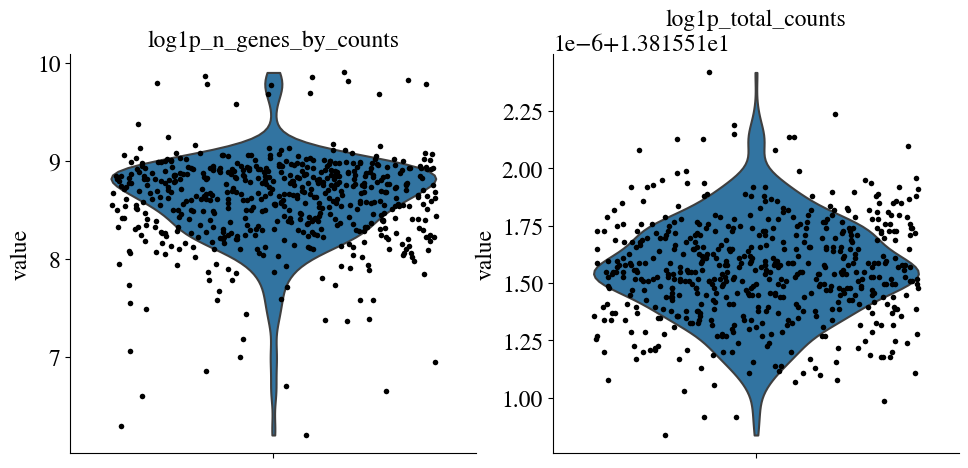

In [45]:
sc.pl.violin(adata, ['log1p_n_genes_by_counts', 'log1p_total_counts'],size = 4,
             jitter=0.4, multi_panel=True)

## *Cell Filtering*
To remove cells with low-quality sequencing values, four filtering criteria were applied:
- Number of total reads
- Mapping rate
- Number of detected genes
- Portion of intergenic region
Utilizing these criteria, the authors choose to removed the following cells, as described in [Supplementary Data 3](https://static-content.springer.com/esm/art%3A10.1038%2Fncomms15081/MediaObjects/41467_2017_BFncomms15081_MOESM467_ESM.xlsx)

We end up with 515 cells, from the original 549.

In [46]:
drop_list = ['BC01_Tumor','BC01_11', 'BC01_24', 'BC01_49', 'BC01_54', 'BC02_27', 'BC02_33', 'BC02_80', 'BC03_45', 'BC03_51', 'BC03_63', 'BC03_88', 'BC03LN_77', 'BC03LN_87', 'BC04_05', 'BC04_06', 'BC04_15', 'BC04_25', 'BC05_40', 'BC06_07', 'BC06_09', 'BC06_22','BC06_45',  'BC06_49', 'BC06_57', 'BC06_62', 'BC07_96', 'BC07LN_20', 'BC08_12','BC09_02', 'BC09_27', 'BC09_54', 'BC09_Re_68', 'BC09_Re_72','BC10_27']
adata = adata[~adata.obs_names.isin(drop_list)]
adata

View of AnnData object with n_obs × n_vars = 528 × 57915
    obs: 'tumor_groups', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## *Gene Filtering, attempt to follow the authors approach to reach 17,779 genes*
Gene filtering was conducted following:
  1. Transcripts Per Million(TPM) values $<$1 were considered unreliable and substituted with zero.

In [47]:
adata.X = np.where(adata.X < 1, 0, adata.X)

  2. TPM values were log2-transformed after adding a value of one.

In [48]:
sc.pp.log1p(adata,base = 2)

  3. Genes expressed in <10% of all tumour groups were removed.

In [49]:
# 10% of the 13 tumor groups is 1.3
threshold = 1.3
df = pd.DataFrame(cell_adata.X, columns=cell_adata.var_names)
# Add the 'tumour_group' annotation as a column in the DataFrame
groups = cell_adata.obs['tumor_groups'].copy()
df['tumor_groups'] = groups.values
grouped_data = df.groupby('tumor_groups')
# Sum the expression and convert any expression value > 0 to 1 to binarize expression
gene_sums = grouped_data.sum()
gene_sums[gene_sums > 0] = 1
# Create a mask that removes genes that are expressed in less than 10% of all clusters
mask = (gene_sums.sum() < threshold)
# Filter the cells 
adata = adata[:, ~mask]

As you can see we end up with 27527 genes rather than 17779 with this method

In [51]:
sc.pp.pca(adata)

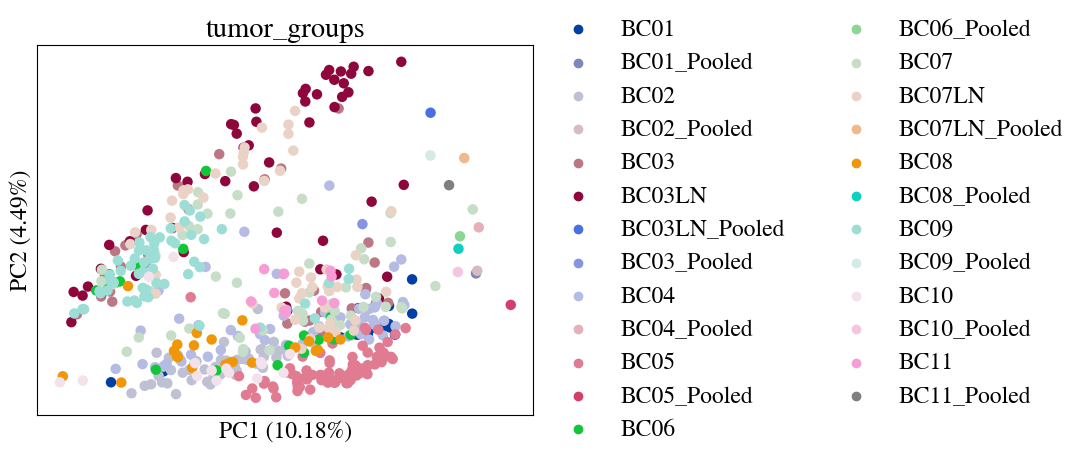

In [52]:
sc.pl.pca(adata, color='tumor_groups',annotate_var_explained = True)
plt.show()